# Betting on ELO Ratings

# Scraping

In [0]:
from bs4 import BeautifulSoup, Comment
import requests
import time
import csv

In [0]:
def get_soup(url):
    '''
    returns BeautifulSoup object of url
    '''
    source = requests.get(url).text
    return BeautifulSoup(source, 'html.parser')

In [0]:
def get_links(url):
    '''
    returns list of game links from pro-football-reference weekly scoreboard
    url_ex = 'https://www.pro-football-reference.com/years/2016/week_1.htm'
    '''
    links = []
    soup = get_soup(url)
    
    for i in soup.find_all('td', class_='right gamelink'):
        link = i.find(href=True)
        links.append('https://www.pro-football-reference.com' + link.get('href'))
    
    return links

In [0]:
def get_data(url):
    '''
    returns dictionary of data from single pro-football-reference game url
    url_ex = 'https://www.pro-football-reference.com/boxscores/201912290cin.htm'
    '''
    
    data = {}
    soup = get_soup(url)
    table = soup.find(id='all_game_info')
    
    # data online is stored in the page source as a comment
    comment = table.find(text=lambda text:isinstance(text, Comment))
    fresh_soup = BeautifulSoup(comment, 'html.parser')
    table_headers = [i.text for i in fresh_soup.find_all('th')]
    table_data = [i.text for i in fresh_soup.find_all('td')[1:]]
    
    for i in range(len(table_headers)):
        data[table_headers[i]] = table_data[i]
    
    return data

In [0]:
def main():
    csv_file = open('line_data.csv', 'w')
    fieldnames = ['Year', 'Week', 'Won Toss', 'Won OT Toss', 'Roof', 'Surface',
    'Duration', 'Attendance', 'Weather', 'Vegas Line', 'Over/Under', 'Link']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()

    years = range(2015, 2020)
    weeks = range(1, 18)

    for year in years:
        for week in weeks:
            game_counter = 1
            time.sleep(1)
            week_url = 'https://www.pro-football-reference.com/years/{}/week_{}.htm'.format(year, week)
            weekly_game_links = get_links(week_url)
            for game in weekly_game_links:
                time.sleep(1)
                game_data = get_data(game)
                game_data['Year'] = year
                game_data['Week'] = week
                game_data['Link'] = game
                writer.writerow(game_data)
                print('{} - {} - {}'.format(year, week, game_counter))
                game_counter += 1

    csv_file.close()

# Data Import

In [0]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
pd.set_option('display.max_rows', None)

For my scraped data (lines), I gathered all the table data elements from the section of pro-football-reference I scraped. On import, I only kept the data necessary for my analysis.

In [0]:
lines = pd.read_csv('https://raw.githubusercontent.com/michael-rowland/DS-Unit-1-Build/master/data/line_data.csv', 
                    usecols=['season', 'week', 'favorite', 'spread'])

For the ELO data (elo), FiveThirtyEight further adjusts their ratings for the quarterback starting for each team. This may be useful to look at for further development, however, for this analysis, I only looked at the standard ratings and probabilities.

In [0]:
elo = pd.read_csv('https://raw.githubusercontent.com/michael-rowland/DS-Unit-1-Build/master/data/nfl_elo.csv',
                  usecols=['date', 'season', 'playoff', 'team1', 'team2', 
                           'elo_prob1', 'elo_prob2', 'elo1_pre', 'elo2_pre', 
                           'score1', 'score2'])

Next I needed a way to convert my points spread data above, to moneyline (a straight-up bet) payouts. While these payouts often vary between different sportsbooks, [this chart](https://wizardofodds.com/games/sports-betting/appendix/11/) seemed to me to be a reasonable mapping between the two.

I had saved this chart as a csv and imported it below. The values were updated to be negative, to match standard notation and my scraped data. This was then merged with the lines dataframe.

In [0]:
ml_conv = pd.read_csv('https://raw.githubusercontent.com/michael-rowland/DS-Unit-1-Build/master/data/moneyline_conversion.csv')

ml_conv['moneyline'] = -ml_conv['moneyline']
ml_conv['spread'] = -ml_conv['spread']

# STRANGELY SPREAD OF ZERO EQUALS NEGATIVE 0.0, SO IT GETS SET TO 0 HERE
ml_conv.iloc[0,0] = 0

lines = pd.merge(lines, ml_conv, on='spread', how='left')

# Data Merge

Several data cleaning steps are necessary to successfully merge the lines dataframe and the elo dataframe.

Mapping the team name (favorite) on the lines dataframe to match the team abbreviations on the elo dataframe.

In [0]:
# UPDATE TEAM NAMES
name_map = {
    'New England Patriots': 'NE', 'Green Bay Packers': 'GB', 
    'Seattle Seahawks': 'SEA', 'Miami Dolphins': 'MIA', 'Houston Texans': 'HOU',
    'Indianapolis Colts': 'IND', 'Carolina Panthers': 'CAR', 
    'New York Jets': 'NYJ', 'San Diego Chargers': 'LAC', 
    'Arizona Cardinals': 'ARI', 'Tampa Bay Buccaneers': 'TB', 
    'Cincinnati Bengals': 'CIN', 'Denver Broncos':  'DEN', 
    'Dallas Cowboys': 'DAL', 'Philadelphia Eagles': 'PHI', 
    'Minnesota Vikings': 'MIN', 'Kansas City Chiefs': 'KC', 
    'Pittsburgh Steelers': 'PIT', 'New York Giants': 'NYG', 
    'New Orleans Saints': 'NO', 'Tennessee Titans': 'TEN', 
    'St. Louis Rams': 'LAR', 'Baltimore Ravens': 'BAL', 
    'Cleveland Browns': 'CLE', 'Atlanta Falcons': 'ATL', 'Buffalo Bills': 'BUF',
    'Oakland Raiders': 'OAK', 'Jacksonville Jaguars': 'JAX', 
    'Detroit Lions': 'DET', 'Washington Redskins': 'WSH', 
    'Chicago Bears': 'CHI', 'Los Angeles Rams': 'LAR',
    'San Francisco 49ers': 'SF', 'Los Angeles Chargers': 'LAC'
}

lines['favorite'] = lines['favorite'].map(name_map)

Since the data gathered from pro-football-reference only goes back to 2015, and does not contain playoff matchups, we drop these values from the elo dataframe.

In [0]:
# FILTER 'elo' DATA TO ONLY GO BACK TO 2015, MATCHING SCRAPED 'lines' DATA
elo = elo[elo['season'] >= 2015]
# DROP PLAYOFF GAMES
elo = elo[elo['playoff'].isnull()]
elo = elo.reset_index(drop=True)
elo = elo.drop(['playoff'], axis=1)

The elo dataset only provides a date column for each game. However, for this analysis, I will need to be able to group the data by week. The following function generates the necessary week column.

In [0]:
# UPDATE 'date' COLUMN TO WEEK (1-17) ON 'elo' DATASET
elo['date'] = pd.to_datetime(elo['date'], format='%Y-%m-%d')

def week_calculator(date_list):
  week_list = []
  week = 0
  start = date_list[0]

  for i in range(len(date_list)):
    if date_list[i] < start + datetime.timedelta(days=7):
      week_list.append(week)
    else:
      week += 1
      week_list.append(week)
      start = date_list[i]
  
  return [week_list[i] % 17 + 1 for i in range(len(week_list))]

elo['week'] = week_calculator(elo['date'].tolist())
elo = elo.drop(['date'], axis=1)

The data gathered from pro-football-reference only contains the team favored in each game. This does not neatly correspond to either the 'team1' or 'team2' column in the elo dataframe. Sometimes the team listed as 'team1' is the favorite, other times it is 'team2'. In response to this, we will have to merge the data twice, once for favorites within 'team1', and a second time for favorites within 'team2'. 

First, we generate unique ID's for both 'team1' and 'team2'. This is a string consisting of the team name, season, and week. This ensures each row has a unique ID.

For the lines dataframe, although there is only one team/favorite, the pandas merge method requires matching id's, so this process is also done twice resulting in 'id1' and 'id2'.

In [0]:
# CREATE TWO UNIQUE IDS TO USE IN MERGE
elo['id1'] = elo['team1'] + elo['season'].astype(str) + elo['week'].astype(str)
elo['id2'] = elo['team2'] + elo['season'].astype(str) + elo['week'].astype(str)
lines['id1'] = lines['favorite'] + lines['season'].astype(str) + lines['week'].astype(str)
lines['id2'] = lines['favorite'] + lines['season'].astype(str) + lines['week'].astype(str)

The data can now be merged. First merging on 'id1', second merging on 'id2' which is saved to a placeholder dataframe, and finally updating the omitted values in the first merge with the values from the second.

In [0]:
# MERGE 'elo' AND 'lines' DATAFRAMES
elo_lines = pd.merge(elo, lines[['favorite', 'spread', 'moneyline', 'id1']], 
                     on='id1', how='left')
data2 = pd.merge(elo, lines[['favorite', 'spread', 'moneyline', 'id2']], 
                 on='id2', how='left')
elo_lines.update(data2)

We drop the 'id' columns and update the appropriate columns to integers.

In [0]:
elo_lines = elo_lines.drop(['id1', 'id2'], axis=1)
elo_lines[['season', 'score1', 'score2', 'week']] = elo_lines[['season', 'score1', 'score2', 'week']].astype(int)

# Data Processing

The first thing I noticed was that for each game, the higher of the two elo ratings is sometimes in 'elo1_pre', and other times in 'elo2_pre'. This will be an issue, when ranking the highest or lowest rated teams each week. The 'resort' function addresses this, and is applied to the data.

In [609]:
elo_lines.head()

,season,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,score1,score2,week,favorite,spread,moneyline
0,2015,NE,PIT,1663.864,1562.771,0.722342,0.277658,28,21,1,NE,-7.0,-231.0
1,2015,JAX,CAR,1356.572,1535.596,0.341554,0.658446,9,20,1,CAR,-3.0,-143.0
2,2015,LAR,SEA,1476.945,1677.552,0.314187,0.685813,34,31,1,SEA,-4.0,-161.0
3,2015,CHI,GB,1419.227,1601.039,0.337954,0.662046,23,31,1,GB,-6.5,-217.0
4,2015,WSH,MIA,1371.453,1483.514,0.432685,0.567315,10,17,1,MIA,-3.0,-143.0


In [0]:
def resort(row):
  '''
  returns a dataframe row where higher rated team's data is first
  '''
  if row['elo_prob1'] < row['elo_prob2']:
    row['team1'], row['team2'] = row['team2'], row['team1']
    row['elo_prob1'], row['elo_prob2'] = row['elo_prob2'], row['elo_prob1']
    row['score1'], row['score2'] = row['score2'], row['score1']
    row['elo1_pre'], row['elo2_pre'] = row['elo2_pre'], row['elo1_pre']
  return row

elo_lines = elo_lines.apply(resort, axis=1)

The next situation we see is that the team elo favors (team1) does not correspond correctly to the team sportsbooks favor (favorite). The 'update_lines' function addresses this. Once the correct odds are associated with 'team1', the 'favorite' column is redundant and can be dropped.

In [611]:
elo_lines[elo_lines['team1'] != elo_lines['favorite']].head()

,season,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,score1,score2,week,favorite,spread,moneyline
5,2015,BUF,IND,1534.055000,1581.097000,0.525821,0.474179,27,14,1,IND,-2.5,-135.0
15,2015,SF,MIN,1528.565000,1479.237000,0.658839,0.341161,20,3,1,MIN,-1.5,-120.0
21,2015,CLE,TEN,1399.048032,1384.750191,0.612178,0.387822,28,14,2,TEN,-2.0,-127.0
34,2015,DAL,ATL,1617.716149,1493.442117,0.748297,0.251703,28,39,3,ATL,-1.0,-114.0
48,2015,PIT,BAL,1593.700683,1521.748404,0.687479,0.312521,20,23,4,BAL,-2.5,-135.0


In [0]:
def update_lines(row):
  '''
  returns a dataframe row with corrected favorite, spread, and moneyline
  '''
  if row['team1'] != row['favorite']:
    row['favorite'] = row['team1']
    row['spread'] = -row['spread']
    row['moneyline'] = -row['moneyline']
  return row

elo_lines = elo_lines.apply(update_lines, axis=1)
elo_lines = elo_lines.drop(['favorite'], axis=1)

To backtest our betting strategy, we must calculate moneyline payouts for each game. This is done in two parts. First the function 'payout_calculator' simply returns the correct payout. More info on this can be found: [here](https://en.wikipedia.org/wiki/Fixed-odds_betting#Moneyline_odds).

In [0]:
def payout_calculator(moneyline):
  '''
  returns a moneyline payout
  '''
  if moneyline > 0:
    return moneyline
  return round(100 / -moneyline * 100, 2)

Second, the function 'win_loss_moneyline' determines the game outcome (win, loss, tie) and applies the appropriate payout.

It is worth noting here that we are assuming $100 wagers. This is standard practice, and corresponds correctly to the moneyline data, so no scaling is necessary.

In [0]:
def win_loss_moneyline(row):
  '''
  returns row with additional 'ml_earnings' column based on game outcome and 
  moneyline odds
  '''
  if row['score1'] > row['score2']:
    row['ml_earnings'] = payout_calculator(row['moneyline'])
  elif row['score1'] == row['score2']:
    row['ml_earnings'] = 0
  else:
    row['ml_earnings'] = -100
  return row

elo_lines = elo_lines.apply(win_loss_moneyline, axis=1)

We then group our data by both season and week and assign data for highest rated favorite and lowest rated underdog.

It is easiest if we encode the data so that "1-3" is the data we are selecting. This because the largest number is not always 16 as the number of games played is not consistent each week.

In [0]:
elo_lines['elo_rank_best'] = elo_lines.groupby(['season', 'week'])['elo1_pre'].rank(ascending=False, method='first')
elo_lines['elo_rank_worst'] = elo_lines.groupby(['season', 'week'])['elo2_pre'].rank(ascending=True, method='first')

# THIS DATAFRAME IS NOT USED BELOW, BUT COULD BE USEFUL FOR FURTHER DEVELOPMENT
# elo_lines['elo_prob_best'] = elo_lines.groupby(['season', 'week'])['elo_prob1'].rank(ascending=False, method='first')

## Basic Exploration

Once the data is cleaned, we can take a look around

In [616]:
# EXAMPLE OF CLEANED DATA: WEEK 17 OF 2019 DATA
elo_lines.tail(16)

,season,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,score1,score2,week,spread,moneyline,ml_earnings,elo_rank_best,elo_rank_worst
1264,2019,CLE,CIN,1439.098968,1290.642050,0.617846,0.382154,23,33,17,-2.5,-135.0,-100.00,16.0,1.0
1265,2019,TB,ATL,1518.716617,1526.000556,0.582304,0.417696,22,28,17,-1.0,-114.0,-100.00,13.0,14.0
1266,2019,NE,MIA,1680.877424,1337.288421,0.913095,0.086905,24,27,17,-17.5,-808.0,-100.00,3.0,3.0
1267,2019,GB,DET,1625.761361,1360.450461,0.760073,0.239927,23,20,17,-13.5,-501.0,19.96,5.0,5.0
1268,2019,MIN,CHI,1613.846589,1517.344505,0.717011,0.282989,19,21,17,5.0,182.0,-100.00,6.0,12.0
1269,2019,KC,LAC,1687.970586,1459.687014,0.843997,0.156003,31,21,17,-10.0,-330.0,30.30,2.0,11.0
1270,2019,NO,CAR,1678.683723,1387.673848,0.786006,0.213994,42,10,17,-13.5,-501.0,19.96,4.0,7.0
1271,2019,BUF,NYJ,1561.367141,1398.014909,0.788265,0.211735,6,13,17,1.5,120.0,-100.00,9.0,8.0
1272,2019,PHI,NYG,1551.327497,1351.254830,0.685150,0.314850,34,17,17,-4.0,-161.0,62.11,11.0,4.0
1273,2019,HOU,TEN,1584.215388,1542.863113,0.648445,0.351555,14,35,17,10.0,330.0,-100.00,7.0,15.0


In [617]:
elo_lines.describe()

,season,elo1_pre,elo2_pre,elo_prob1,elo_prob2,score1,score2,week,spread,moneyline,ml_earnings,elo_rank_best,elo_rank_worst
count,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000
mean,2017.000000,1553.499530,1456.563730,0.658942,0.341058,24.979688,20.405469,9.050781,-4.255469,-159.067187,3.983531,8.066406,8.066406
std,1.414766,82.588679,86.139451,0.102412,0.102412,9.940773,9.509247,5.012237,4.466403,171.497156,81.936074,4.401059,4.401059
min,2015.000000,1299.181235,1201.561463,0.500077,0.046056,0.000000,0.000000,1.000000,-22.000000,-1383.000000,-100.000000,1.000000,1.000000
25%,2016.000000,1496.363248,1394.904972,0.572475,0.266971,18.000000,14.000000,5.000000,-7.000000,-231.000000,-100.000000,4.000000,4.000000
50%,2017.000000,1553.969850,1458.181161,0.647227,0.352773,24.000000,20.000000,9.000000,-3.500000,-152.000000,40.820000,8.000000,8.000000
75%,2018.000000,1616.551806,1516.936313,0.733029,0.427525,31.000000,27.000000,13.250000,-2.500000,-135.000000,65.790000,12.000000,12.000000
max,2019.000000,1763.027332,1708.396990,0.953944,0.499923,59.000000,55.000000,17.000000,10.500000,350.000000,245.000000,16.000000,16.000000


# Visualizations

Due to our encoding, we can subset both the top and bottom dataframes by filtering by values less than or equal to 3.

In [0]:
top3 = elo_lines[elo_lines['elo_rank_best'] <= 3]
bottom3 = elo_lines[elo_lines['elo_rank_worst'] <= 3]

One useful statistic we can generate is win percentage. These strategies may be less appealing if they had a positive earnings, however a low winning percentage.

In [0]:
def win_percentage(data):
  win = data[data > 0].count()
  loss = data[data < 0].count()
  return win / (win + loss)

Both the annual, and multi-year plots, are inside of functions. The function can be used for different years or strategies. The values for the cumulative earnings line and final earnings amount are calculated within the function.

In [0]:
def plot_year(plot_data, title, bar=False):
  # STYLING
  plt.style.use('fivethirtyeight')
  fig, ax = plt.subplots(figsize=(10, 6))
  
  # PLOT DATA
  x = range(len(plot_data))
  y = plot_data.cumsum()
  positive = plot_data > 0

  # PLOTTING
  ax.plot(x, y,'black', linewidth=2)
  plt.fill_between(x, 0, y, where=y>0, interpolate=True, 
                   color = 'g', alpha=0.25)
  plt.fill_between(x, 0, y, where=y<0, interpolate=True, 
                   color = 'r', alpha=0.25)
  ax.axhline(y=0, color='black', linewidth=1)
  
  # IF USER SETS bar=True, THIS ADDS BAR PLOT
  if bar == True:
    ax.bar(x=range(len(plot_data)), height=plot_data, 
           color=positive.map({True:'g', False:'r'}), alpha=0.5)

  # SETTING LABELS/TICKS
  ax.set_title(title, fontsize=18, fontweight='bold', y=1.05)
  ax.set_xticks(range(0,len(plot_data),3))
  ax.set_xticklabels(range(1,(int(len(plot_data)/3))+1))
  ax.set_xlabel('Week', fontsize=14, fontweight='bold')
  ax.set_ylabel('Cumulative Earnings', fontsize=14, fontweight='bold')
  ax.tick_params(which='major', labelsize=10)

  # WATERMARK, WITH ROUGH Y-POSITION CALCULATION 
  ymin = y.min() if y.min()<0 else 0
  factor = (y.max()-ymin)/7
  ax.text(x=41, y=ymin-factor, s='GitHub: michael-rowland', fontsize=8, 
          color='grey')

  # SAVING
  plt.savefig('{}.png'.format(title), format='png', dpi=300, 
              bbox_inches='tight')
  # files.download('{}.png'.format(title))

  plt.show()
  print('Final Earnings: {}'.format(round(y.iloc[-1], 2)))


This function calls the plot_year function above, with correctly filtered data. The function has parameters for the year, and a boolean indicator for a bar chart in addition to normal chart.

In [0]:
def year_output(year, bar=False):
  top3_earnings = top3[top3['season'] == year]['ml_earnings']
  bottom3_earnings = bottom3[bottom3['season'] == year]['ml_earnings']

  plot_year(top3_earnings, 
            'Bet On Top 3 ELO Favorites ({})'.format(year), 
            bar=bar)
  print('Win Percentage: {:.2%}\n'.format(win_percentage(top3_earnings)))

  plot_year(bottom3_earnings, 
            'Bet Against Bottom 3 ELO Underdogs ({})'.format(year),
            bar=bar)
  print('Win Percentage: {:.2%}\n'.format(win_percentage(bottom3_earnings)))

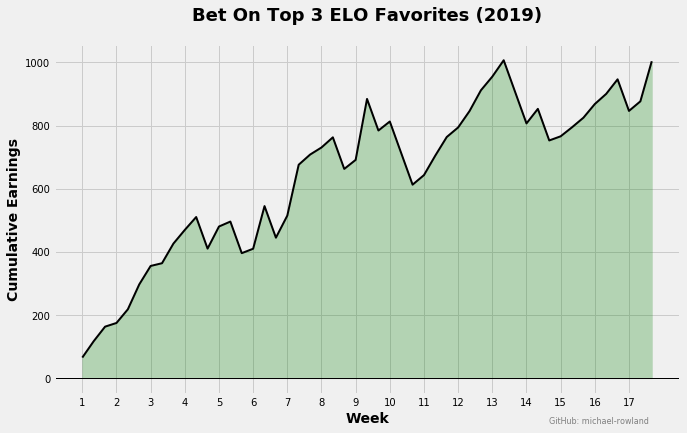

Final Earnings: 1003.96
Win Percentage: 78.43%



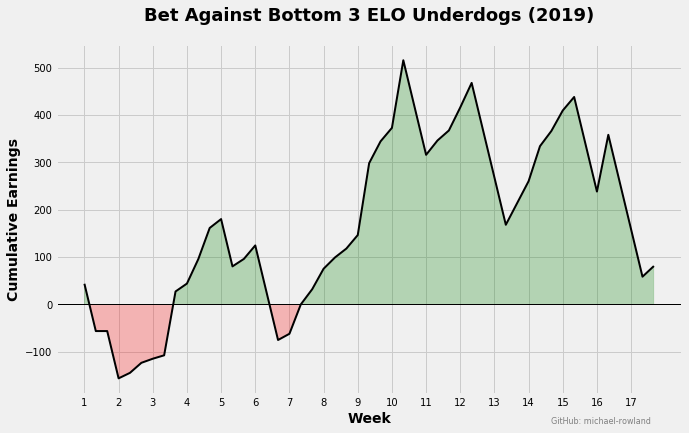

Final Earnings: 80.77
Win Percentage: 70.00%



In [623]:
year_output(2019)

Example of added bar chart

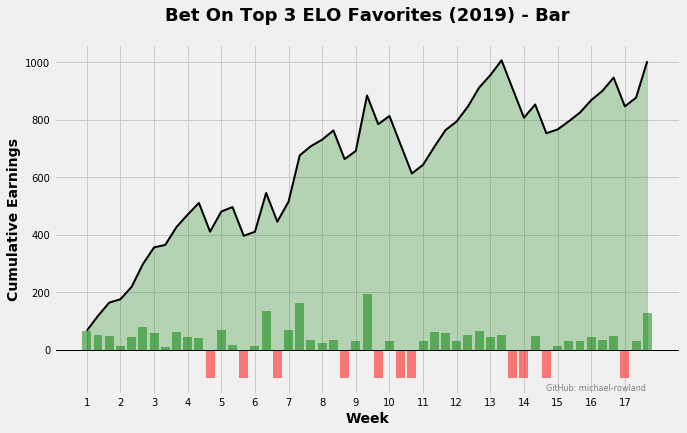

Final Earnings: 1003.96


In [624]:
plot_year(top3[top3['season'] == year]['ml_earnings'], 
          'Bet On Top 3 ELO Favorites (2019) - Bar', bar=True)

In [0]:
def plot_total(plot_data, title, bar=False):
  # STYLING
  plt.style.use('fivethirtyeight')
  fig, ax = plt.subplots(figsize=(10, 6))
  
  # PLOT DATA
  x = range(len(plot_data))
  y = plot_data.cumsum()
  positive = plot_data > 0

  # PLOTTING
  ax.plot(x, y,'black', linewidth=2)
  plt.fill_between(x, 0, y, where=y>0, interpolate=True, 
                   color = 'g', alpha=0.25)
  plt.fill_between(x, 0, y, where=y<0, interpolate=True, 
                   color = 'r', alpha=0.25)
  ax.axhline(y=0, color='black', linewidth=1)
  
  # IF USER SETS bar=True, THIS ADDS BAR PLOT
  if bar == True:
    ax.bar(x=range(len(plot_data)), height=plot_data, 
           color=positive.map({True:'g', False:'r'}), alpha=0.5)

  # SETTING LABELS/TICKS
  ax.set_title(title, fontsize=18, fontweight='bold')
  ax.set_xticks(range(0,len(plot_data),53))
  ax.set_xticklabels(range(2015,2020))
  ax.set_xlabel('Year', fontsize=14, fontweight='bold')
  ax.set_ylabel('Cumulative Earnings', fontsize=14, fontweight='bold')
  ax.tick_params(which='major', labelsize=10)

  # WATERMARK, WITH ROUGH Y-POSITION CALCULATION 
  ymin = y.min() if y.min()<0 else 0
  factor = (y.max()-ymin)/7
  ax.text(x=210, y=ymin-factor, s='GitHub: michael-rowland', fontsize=8, 
          color='grey')

  # SAVING
  plt.savefig('{}.png'.format(title), format='png', dpi=300, 
              bbox_inches='tight')
  # files.download('{}.png'.format(title))  

  plt.show()
  print('Final Earnings: {}'.format(round(y.iloc[-1], 2)))

This function calls the plot_total function above, with correct data.

In [0]:
def total_output(bar=False):
  top3_earnings = top3['ml_earnings']
  bottom3_earnings = bottom3['ml_earnings']

  plot_total(top3_earnings, 
            'Bet On Top 3 ELO Favorites (2015-2019)', 
            bar=bar)
  print('Win Percentage: {:.2%}\n'.format(win_percentage(top3_earnings)))

  plot_total(bottom3_earnings, 
            'Bet Against Bottom 3 ELO Underdogs (2015-2019)',
            bar=bar)
  print('Win Percentage: {:.2%}\n'.format(win_percentage(bottom3_earnings)))

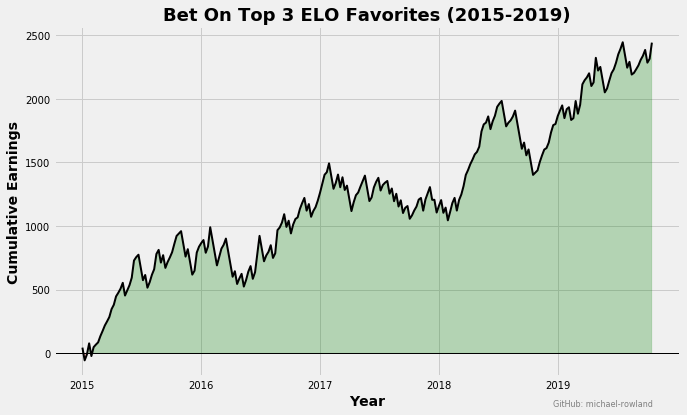

Final Earnings: 2440.24
Win Percentage: 72.83%



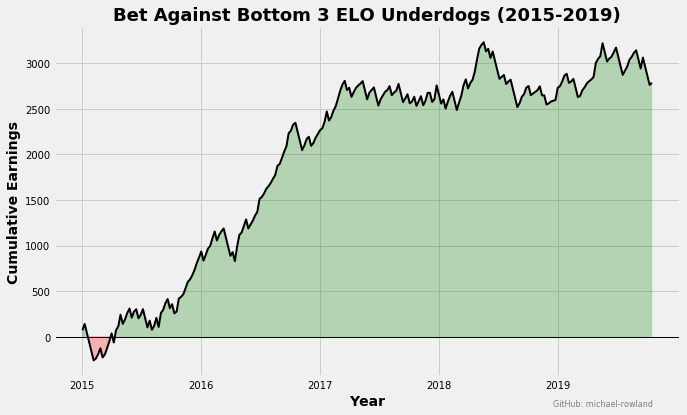

Final Earnings: 2785.97
Win Percentage: 71.94%



In [627]:
total_output()